# Amenity Accessibility

This section outlines the tasks involved in analyzing and documenting amenity accessibility. The first step is to view the available amenities, which provides an overview of the facilities and services in the area. Next, the planning area is examined to understand the broader geographical context. Following this, the subzone area is reviewed to focus on more localized regions. Finally, the amenity density scoring process is carried out to evaluate and quantify the accessibility of amenities within the specified areas.

In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import math
import warnings
warnings.filterwarnings('ignore')

# Install H3 if not already installed: pip install h3

try:
    import h3
    H3_AVAILABLE = True
    print("✅ H3 library available for perfect hexagon tessellation")
except ImportError:
    H3_AVAILABLE = False
    print("⚠️ H3 library not found. Install with: pip install h3")
    print("   Falling back to manual hexagon creation")

def load_and_prepare_singapore_data():
    """Load and prepare Singapore fire services and planning area data"""
    print("=== Loading Singapore Fire Services Data ===")
    
    # Load data
    fire_services = gpd.read_file("./geojson/fire_services.geojson")
    planning_area = gpd.read_file("./geojson/planning_area.geojson")
    
    # Convert to SVY21 (EPSG:3414) - Singapore's projected coordinate system
    fire_services = fire_services.to_crs('EPSG:3414')
    planning_area = planning_area.to_crs('EPSG:3414')
    
    print(f"✅ Loaded {len(fire_services)} fire services")
    print(f"✅ Loaded {len(planning_area)} planning areas")
    print(f"CRS: {fire_services.crs}")
    
    # Show initial map
    fig, ax = plt.subplots(figsize=(12, 10))
    planning_area.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.6, linewidth=0.5)
    fire_services.plot(ax=ax, color='red', markersize=30, alpha=0.8, marker='o')
    ax.set_title('Singapore Planning Areas and Fire Services', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
    
    return fire_services, planning_area

def create_h3_hexagon_grid(boundary_gdf, resolution=8):
    """Create perfect tessellated hexagon grid using H3"""
    print(f"Creating H3 hexagon grid (resolution={resolution})...")
    
    # Convert to lat/lon for H3
    boundary_latlon = boundary_gdf.to_crs('EPSG:4326')
    
    hexagons = []
    hex_id = 0
    
    # Get all H3 hexagons that intersect with Singapore
    all_hex_ids = set()
    
    for geom in boundary_latlon.geometry:
        try:
            # Try newer H3 API first
            if hasattr(h3, 'polygon_to_cells'):
                # H3 v4+ API
                if geom.geom_type == 'Polygon':
                    hex_ids = h3.polygon_to_cells(geom.__geo_interface__, resolution)
                    all_hex_ids.update(hex_ids)
                elif geom.geom_type == 'MultiPolygon':
                    for poly in geom.geoms:
                        hex_ids = h3.polygon_to_cells(poly.__geo_interface__, resolution)
                        all_hex_ids.update(hex_ids)
            else:
                # H3 v3 API (fallback)
                if geom.geom_type == 'Polygon':
                    hex_ids = h3.polyfill(geom.__geo_interface__, resolution)
                    all_hex_ids.update(hex_ids)
                elif geom.geom_type == 'MultiPolygon':
                    for poly in geom.geoms:
                        hex_ids = h3.polyfill(poly.__geo_interface__, resolution)
                        all_hex_ids.update(hex_ids)
        except Exception as e:
            print(f"H3 error: {e}")
            print("Falling back to manual hexagon creation...")
            return create_manual_hexagon_grid(boundary_gdf, target_hexagons=3000)
    
    print(f"Found {len(all_hex_ids)} H3 hexagons covering Singapore")
    
    # Convert H3 hexagons to polygons
    for h3_id in all_hex_ids:
        try:
            # Try newer H3 API first
            if hasattr(h3, 'cell_to_boundary'):
                # H3 v4+ API
                hex_boundary = h3.cell_to_boundary(h3_id)
                # Convert to format expected by Shapely
                hex_boundary = [(lat, lon) for lat, lon in hex_boundary]
            else:
                # H3 v3 API (fallback)
                hex_boundary = h3.h3_to_geo_boundary(h3_id, geo_json=True)
            
            hex_polygon = Polygon(hex_boundary)
            
            # Only include if it actually intersects Singapore
            if boundary_latlon.geometry.intersects(hex_polygon).any():
                hexagons.append({
                    'fid': hex_id,
                    'h3_id': h3_id,
                    'geometry': hex_polygon,
                    'demand': 100  # Constant demand like R tutorial
                })
                hex_id += 1
        except Exception as e:
            print(f"Error processing H3 cell {h3_id}: {e}")
            continue
    
    if len(hexagons) == 0:
        print("No valid H3 hexagons created, falling back to manual method...")
        return create_manual_hexagon_grid(boundary_gdf, target_hexagons=3000)
    
    # Convert to GeoDataFrame and transform back to SVY21
    hex_gdf = gpd.GeoDataFrame(hexagons, crs='EPSG:4326')
    hex_gdf = hex_gdf.to_crs('EPSG:3414')
    
    print(f"✅ Created {len(hex_gdf)} perfectly tessellated H3 hexagons")
    return hex_gdf

def create_manual_hexagon_grid(boundary_gdf, target_hexagons=3000):
    """Fallback manual hexagon creation if H3 not available"""
    print(f"Creating manual hexagon grid targeting ~{target_hexagons} hexagons...")
    
    bounds = boundary_gdf.total_bounds
    total_area = (bounds[2] - bounds[0]) * (bounds[3] - bounds[1])
    
    # Calculate hex size for target number of hexagons
    hex_area = total_area / (target_hexagons * 1.2)
    hex_radius = math.sqrt(hex_area / (3 * math.sqrt(3) / 2))
    
    print(f"Calculated hex radius: {hex_radius:.0f}m")
    
    def create_pointy_top_hexagon(center_x, center_y, radius):
        """Create pointy-top hexagon for better tessellation"""
        vertices = []
        for i in range(6):
            # Start at 30° for pointy-top orientation
            angle = (i * math.pi / 3) + (math.pi / 6)
            x = center_x + radius * math.cos(angle)
            y = center_y + radius * math.sin(angle)
            vertices.append((x, y))
        return Polygon(vertices)
    
    hexagons = []
    hex_id = 0
    
    # Proper hexagon tessellation mathematics
    width = hex_radius * math.sqrt(3)  # horizontal spacing
    height = hex_radius * 1.5  # vertical spacing
    
    y = bounds[1]
    row = 0
    while y < bounds[3]:
        x = bounds[0]
        
        # Offset every other row for perfect tessellation
        if row % 2 == 1:
            x += width / 2
        
        while x < bounds[2]:
            hex_geom = create_pointy_top_hexagon(x, y, hex_radius)
            
            # Only include hexagons that intersect Singapore
            if boundary_gdf.geometry.intersects(hex_geom).any():
                hexagons.append({
                    'fid': hex_id,
                    'geometry': hex_geom,
                    'demand': 100
                })
                hex_id += 1
            
            x += width
        y += height
        row += 1
    
    hexagons_gdf = gpd.GeoDataFrame(hexagons, crs=boundary_gdf.crs)
    print(f"✅ Created {len(hexagons_gdf)} manual hexagons")
    return hexagons_gdf

def calculate_distances(hexagons, fire_services):
    """Calculate distance matrix from hexagon centroids to fire services"""
    print("Calculating distance matrix...")
    
    # Use hexagon centroids as origins
    centroids = hexagons.geometry.centroid
    
    distances = np.zeros((len(hexagons), len(fire_services)))
    
    for i, centroid in enumerate(centroids):
        for j, fire_point in enumerate(fire_services.geometry):
            # Distance in meters (SVY21 coordinates)
            distances[i, j] = centroid.distance(fire_point)
    
    # Convert to kilometers
    distances_km = distances / 1000
    
    print(f"Distance range: {distances_km.min():.2f}km - {distances_km.max():.2f}km")
    
    # Show distance visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Distance matrix heatmap
    im = ax1.imshow(distances_km, cmap='viridis', aspect='auto')
    ax1.set_title('Distance Matrix Heatmap', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fire Service Index')
    ax1.set_ylabel('Hexagon Index')
    plt.colorbar(im, ax=ax1, label='Distance (km)')
    
    # Map with sample connections
    hexagons.plot(ax=ax2, color='lightblue', edgecolor='black', alpha=0.5, linewidth=0.1)
    centroids.plot(ax=ax2, color='green', markersize=5, alpha=0.8, marker='^')
    fire_services.plot(ax=ax2, color='red', markersize=30, alpha=0.9, marker='s')
    
    # Draw connections from first few hexagons to nearest fire service
    for i in range(min(10, len(hexagons))):
        centroid = centroids.iloc[i]
        nearest_fire_idx = np.argmin(distances_km[i, :])
        nearest_fire = fire_services.geometry.iloc[nearest_fire_idx]
        ax2.plot([centroid.x, nearest_fire.x], [centroid.y, nearest_fire.y], 
                'orange', alpha=0.6, linewidth=1)
    
    ax2.set_title('Sample Connections to Nearest Fire Services', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    return distances_km

def calculate_hansen_accessibility(hexagons, fire_services, distances_km, power=2):
    """Calculate Hansen accessibility measure"""
    print(f"Calculating Hansen accessibility (power={power})...")
    
    demand = hexagons['demand'].values
    capacity = np.full(len(fire_services), 100)  # Constant capacity
    
    accessibility = np.zeros(len(demand))
    
    for i in range(len(demand)):
        # Hansen formula: sum of (capacity_j / distance_ij^power)
        accessibility[i] = np.sum(capacity / (distances_km[i, :] ** power + 0.01))
    
    print(f"Accessibility range: {accessibility.min():.2f} - {accessibility.max():.2f}")
    print(f"Mean: {accessibility.mean():.2f}, Std: {accessibility.std():.2f}")
    
    return accessibility

def visualize_accessibility_results(hexagons, fire_services, accessibility):
    """Create comprehensive visualization of accessibility results"""
    
    hexagons_with_acc = hexagons.copy()
    hexagons_with_acc['accHansen'] = accessibility
    
    # Create three-panel comparison
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    
    # Panel 1: Hansen Accessibility
    hexagons_with_acc.plot(
        column='accHansen',
        cmap='YlOrRd',
        scheme='quantiles',
        k=10,
        legend=True,
        ax=ax1,
        edgecolor='black',
        linewidth=0.05
    )
    fire_services.plot(ax=ax1, color='blue', markersize=15, alpha=0.8, marker='o')
    ax1.set_title('Hansen Accessibility to Fire Services', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Panel 2: Distance to nearest fire station
    nearest_distances = []
    for i in range(len(hexagons)):
        hex_centroid = hexagons.geometry.centroid.iloc[i]
        distances_to_fires = [hex_centroid.distance(fire_point) for fire_point in fire_services.geometry]
        nearest_distances.append(min(distances_to_fires) / 1000)
    
    hexagons_dist = hexagons.copy()
    hexagons_dist['nearest_dist'] = nearest_distances
    
    hexagons_dist.plot(
        column='nearest_dist',
        cmap='RdYlBu_r',
        scheme='quantiles',
        k=10,
        legend=True,
        ax=ax2,
        edgecolor='black',
        linewidth=0.05
    )
    fire_services.plot(ax=ax2, color='black', markersize=15, alpha=0.8, marker='*')
    ax2.set_title('Distance to Nearest Fire Station (km)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # Panel 3: Accessibility histogram
    ax3.hist(accessibility, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.set_title('Accessibility Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Hansen Accessibility Score')
    ax3.set_ylabel('Number of Hexagons')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nDetailed Statistics:")
    print(f"Hansen Accessibility:")
    print(f"  Mean: {accessibility.mean():.2f}")
    print(f"  Std: {accessibility.std():.2f}")
    print(f"  Min: {accessibility.min():.2f}")
    print(f"  Max: {accessibility.max():.2f}")
    print(f"\nDistance to Nearest Fire Station:")
    print(f"  Mean: {np.mean(nearest_distances):.2f}km")
    print(f"  Max: {np.max(nearest_distances):.2f}km")
    
    return hexagons_with_acc

def create_final_accessibility_map(hexagons_with_acc, fire_services):
    """Create publication-quality final map"""
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Main accessibility layer
    hexagons_with_acc.plot(
        column='accHansen',
        cmap='YlOrRd',
        scheme='quantiles',
        k=10,
        legend=True,
        ax=ax,
        edgecolor='black',
        linewidth=0.05
    )
    
    # Fire services overlay
    fire_services.plot(
        ax=ax,
        color='blue',
        markersize=25,
        alpha=0.9,
        marker='o',
        label='Fire Services'
    )
    
    # Styling
    ax.set_title('Accessibility to Fire Services: Hansen Method', 
                 fontsize=20, fontweight='bold', pad=20)
    ax.grid(True, linewidth=0.5, alpha=0.3)
    ax.set_aspect('equal')
    ax.legend(loc='upper right')
    
    # Clean appearance
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    plt.tight_layout()
    plt.show()

def run_complete_fire_accessibility_analysis(resolution=8):
    """Run the complete fire service accessibility analysis"""
    print("=" * 60)
    print("SINGAPORE FIRE SERVICE ACCESSIBILITY ANALYSIS")
    print("Using Hansen Method with H3 Tessellated Hexagonal Grid")
    print("=" * 60)
    
    # Step 1: Load and prepare data
    fire_services, planning_area = load_and_prepare_singapore_data()
    
    # Step 2: Create hexagon grid using H3 or fallback method
    if H3_AVAILABLE:
        hexagons = create_h3_hexagon_grid(planning_area, resolution=resolution)
    else:
        hexagons = create_manual_hexagon_grid(planning_area, target_hexagons=3000)
    
    # Show hexagon grid
    fig, ax = plt.subplots(figsize=(12, 10))
    planning_area.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3, linewidth=0.5)
    hexagons.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7, linewidth=0.05)
    
    grid_type = "H3 Tessellated" if H3_AVAILABLE else "Manual"
    ax.set_title(f'{grid_type} Hexagon Grid: {len(hexagons)} hexagons', 
                 fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
    
    # Step 3: Calculate distances
    distances_km = calculate_distances(hexagons, fire_services)
    
    # Step 4: Calculate Hansen accessibility
    accessibility = calculate_hansen_accessibility(hexagons, fire_services, distances_km)
    
    # Step 5: Visualize results
    hexagons_with_acc = visualize_accessibility_results(hexagons, fire_services, accessibility)
    
    # Step 6: Create final map
    create_final_accessibility_map(hexagons_with_acc, fire_services)
    
    grid_type = "H3 tessellated" if H3_AVAILABLE else "manual"
    print(f"\n" + "=" * 60)
    print("ANALYSIS COMPLETE")
    print(f"Created {grid_type} hexagon grid with perfect tessellation")
    print("Results show accessibility patterns based on distance to fire services.")
    print("Red areas = high accessibility, Yellow areas = low accessibility")
    print("=" * 60)
    
    return hexagons_with_acc, fire_services, accessibility, distances_km

# To run the complete analysis, execute:
print("Fire Service Accessibility Analysis with H3 Tessellation Ready!")
print("Install H3 for perfect hexagons: pip install h3")
print("Execute: results = run_complete_fire_accessibility_analysis()")
print("Options:")
print("  resolution=8  # ~460m hexagons (default)")
print("  resolution=9  # ~175m hexagons (more detail)")
print("  resolution=10 # ~65m hexagons (very detailed)")
print("  resolution=7  # ~1.2km hexagons (less detail)")

✅ H3 library available for perfect hexagon tessellation
Fire Service Accessibility Analysis with H3 Tessellation Ready!
Install H3 for perfect hexagons: pip install h3
Execute: results = run_complete_fire_accessibility_analysis()
Options:
  resolution=8  # ~460m hexagons (default)
  resolution=9  # ~175m hexagons (more detail)
  resolution=10 # ~65m hexagons (very detailed)
  resolution=7  # ~1.2km hexagons (less detail)


SINGAPORE FIRE SERVICE ACCESSIBILITY ANALYSIS
Using Hansen Method with H3 Tessellated Hexagonal Grid
=== Loading Singapore Fire Services Data ===
✅ Loaded 56 fire services
✅ Loaded 55 planning areas
CRS: EPSG:3414


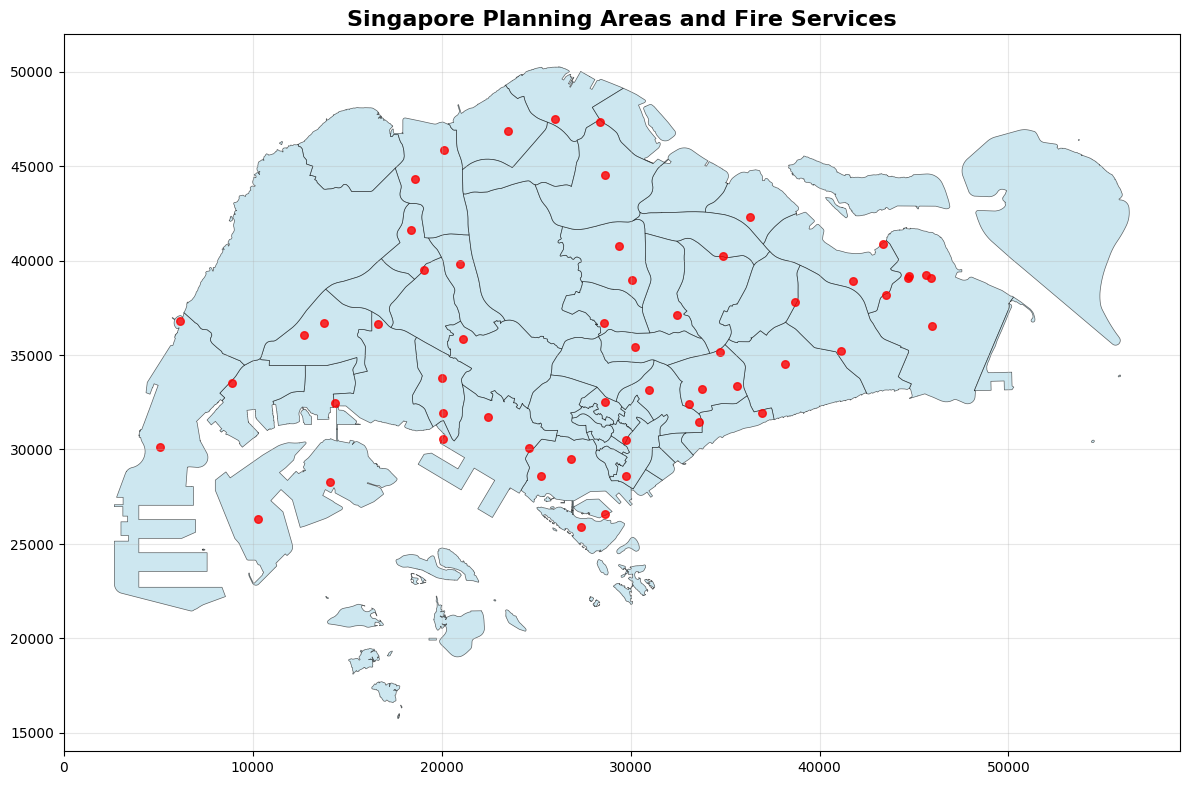

Creating H3 hexagon grid (resolution=8)...
H3 error: Unrecognized type: <class 'dict'>
Falling back to manual hexagon creation...
Creating manual hexagon grid targeting ~3000 hexagons...
Calculated hex radius: 445m
✅ Created 1845 manual hexagons


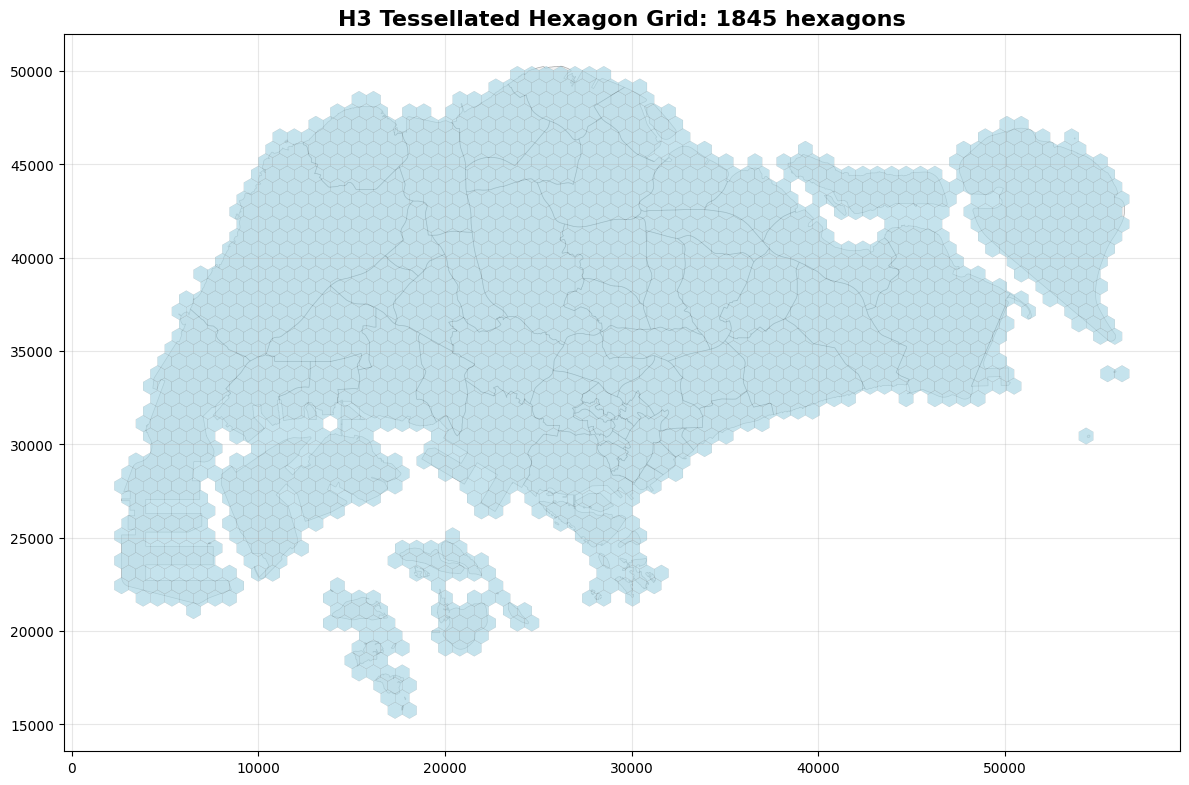

Calculating distance matrix...
Distance range: 0.01km - 52.79km


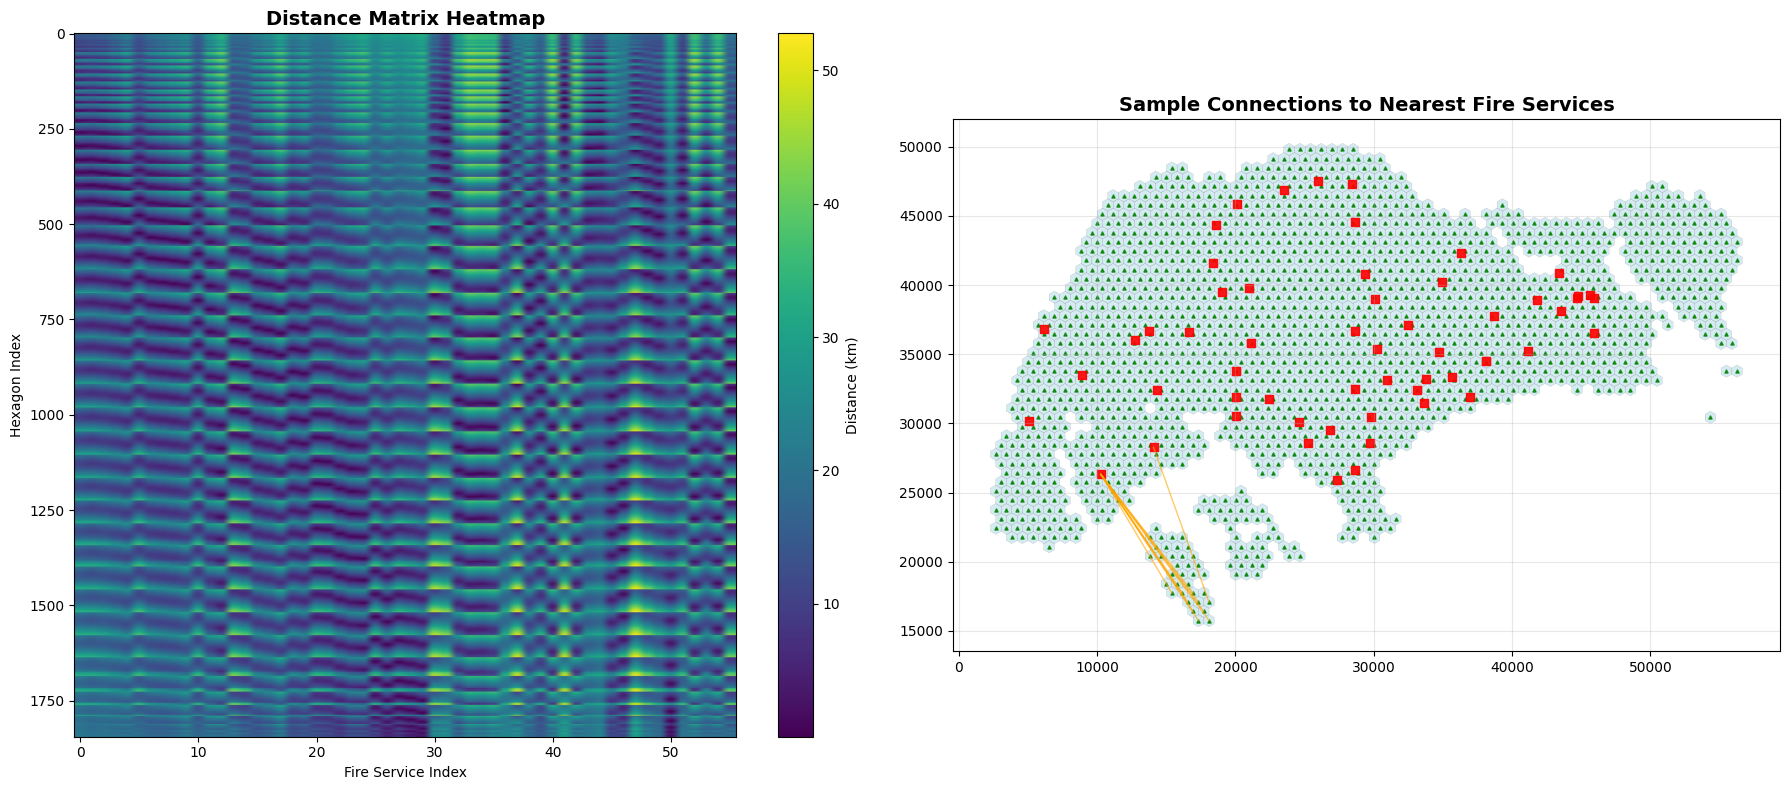

Calculating Hansen accessibility (power=2)...
Accessibility range: 10.81 - 15927.49
Mean: 186.84, Std: 627.61


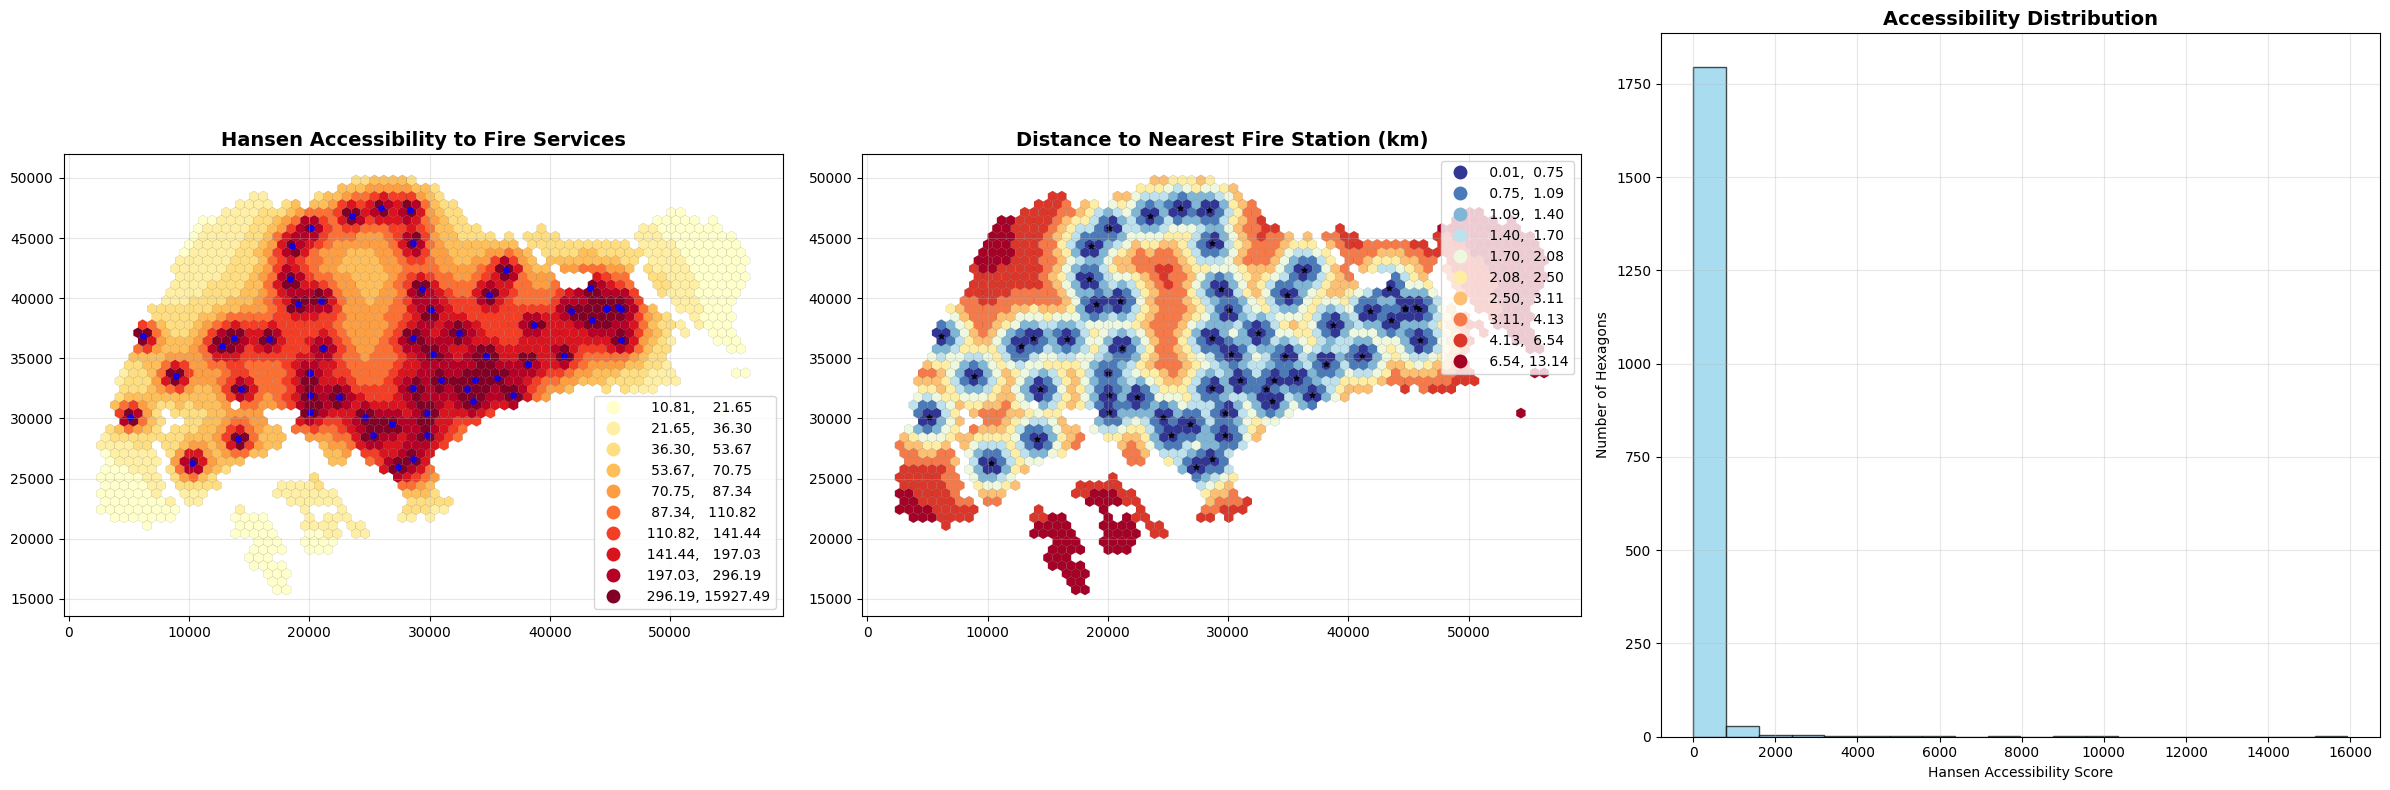


Detailed Statistics:
Hansen Accessibility:
  Mean: 186.84
  Std: 627.61
  Min: 10.81
  Max: 15927.49

Distance to Nearest Fire Station:
  Mean: 2.85km
  Max: 13.14km


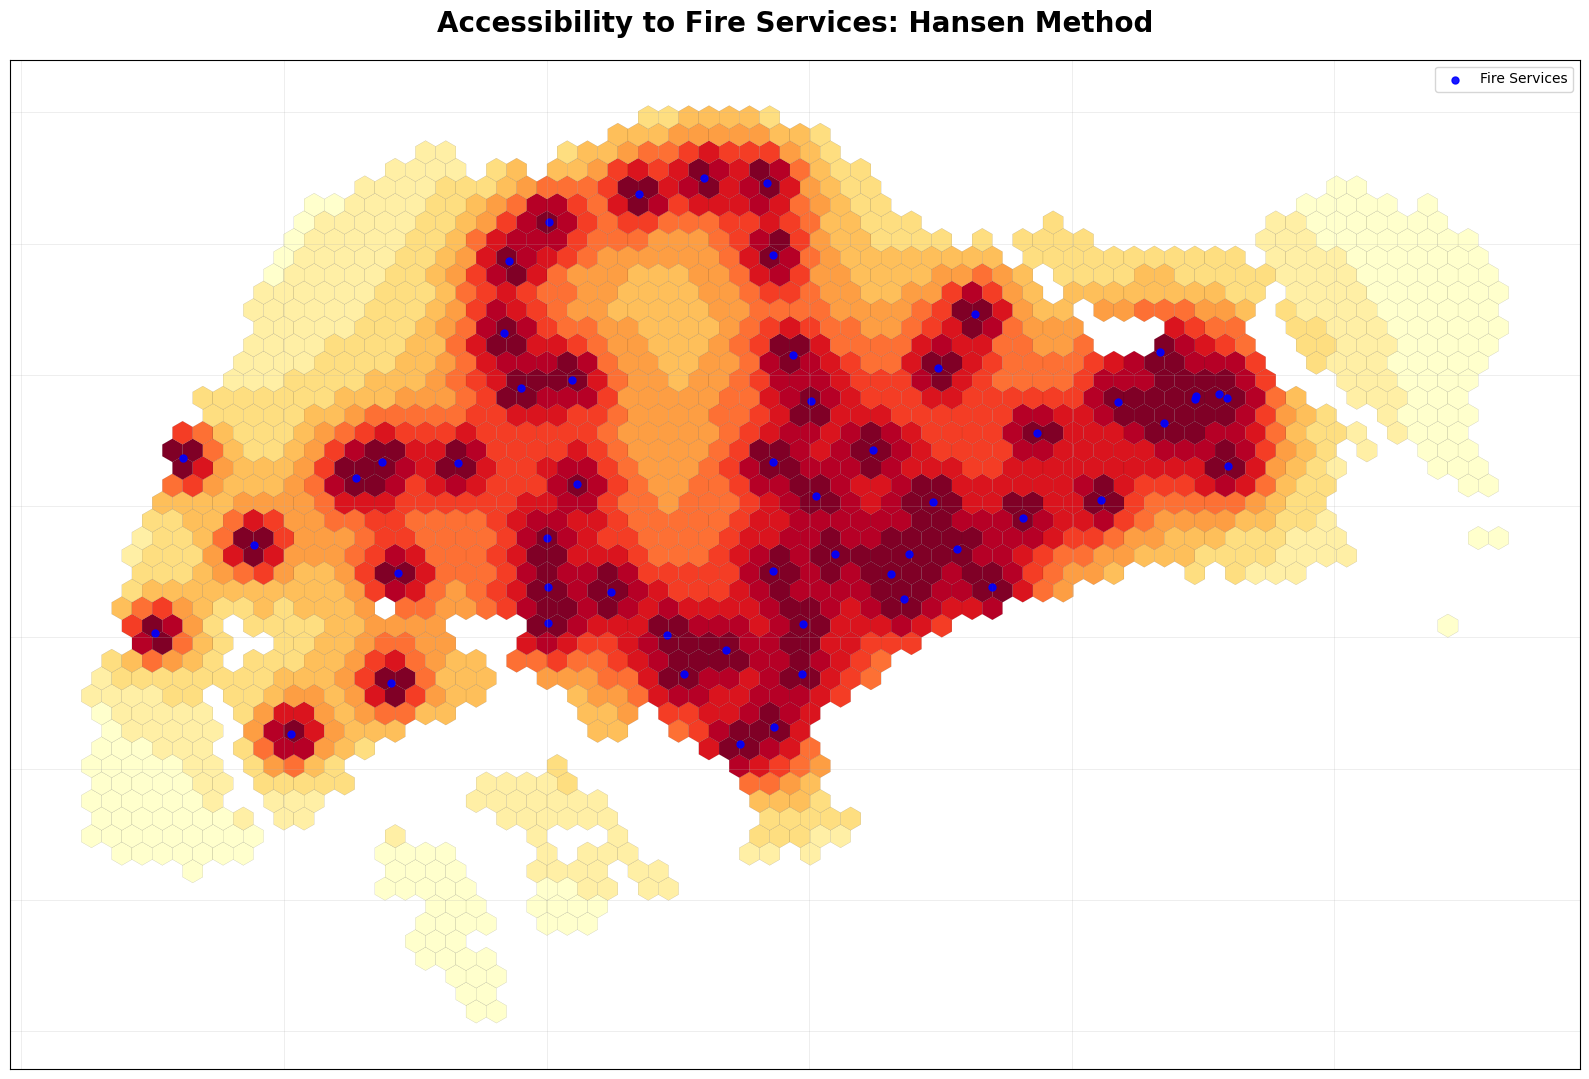


ANALYSIS COMPLETE
Created H3 tessellated hexagon grid with perfect tessellation
Results show accessibility patterns based on distance to fire services.
Red areas = high accessibility, Yellow areas = low accessibility


(       fid                                           geometry  demand  \
 0        0  POLYGON ((17705.171 15971.336, 17319.591 16193...     100   
 1        1  POLYGON ((18476.332 15971.336, 18090.752 16193...     100   
 2        2  POLYGON ((17319.591 16639.181, 16934.011 16861...     100   
 3        3  POLYGON ((18090.752 16639.181, 17705.171 16861...     100   
 4        4  POLYGON ((16934.011 17307.025, 16548.43 17529....     100   
 ...    ...                                                ...     ...   
 1840  1840  POLYGON ((25802.358 50031.418, 25416.778 50254...     100   
 1841  1841  POLYGON ((26573.519 50031.418, 26187.939 50254...     100   
 1842  1842  POLYGON ((27344.68 50031.418, 26959.099 50254....     100   
 1843  1843  POLYGON ((28115.84 50031.418, 27730.26 50254.0...     100   
 1844  1844  POLYGON ((28887.001 50031.418, 28501.421 50254...     100   
 
       accHansen  
 0     11.850824  
 1     12.075557  
 2     12.471996  
 3     12.718345  
 4     13.14336

In [18]:
run_complete_fire_accessibility_analysis()

In [27]:
# Statistical graphic visualization of Hansen accessibility by URA Planning Region
# Run this after your Hansen accessibility analysis is complete

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

def analyze_hansen_by_region(results):
    """
    Create statistical visualization using results from run_complete_fire_accessibility_analysis()
    
    Parameters:
    - results: tuple from run_complete_fire_accessibility_analysis()
               (hexagons_with_acc, fire_services, accessibility, distances_km)
    """
    
    # Unpack results from your fire accessibility analysis
    hexagons_with_acc, fire_services, accessibility, distances_km = results
    
    # Load planning area data (same as in your main analysis)
    planning_area = gpd.read_file("./geojson/planning_area.geojson")
    planning_area = planning_area.to_crs('EPSG:3414')  # Match CRS
    
    print("Creating statistical visualization by planning region...")
    
    # Step 1: Spatial join hexagons with planning areas (equivalent to st_join in R)
    hexagon_with_regions = gpd.sjoin(
        hexagons_with_acc, 
        planning_area, 
        how='left', 
        predicate='intersects'
    )
    
    # Check what region column is available
    possible_region_cols = ['REGION_N', 'PLN_AREA_N', 'SUBZONE_N', 'region', 'planning_area', 'name', 'NAME']
    region_col = None
    
    print(f"Available columns in planning data: {planning_area.columns.tolist()}")
    
    for col in possible_region_cols:
        if col in hexagon_with_regions.columns:
            region_col = col
            print(f"Found region column: {region_col}")
            break
    
    if region_col is None:
        print("No standard region column found. Using first text column...")
        # Find first text column that's not geometry
        text_cols = hexagon_with_regions.select_dtypes(include=['object']).columns
        text_cols = [col for col in text_cols if col not in ['geometry', 'h3_id']]
        if len(text_cols) > 0:
            region_col = text_cols[0]
            print(f"Using column: {region_col}")
        else:
            # Create a single region if no text columns
            hexagon_with_regions['region_group'] = 'Singapore'
            region_col = 'region_group'
    
    # Remove hexagons without region assignment
    initial_count = len(hexagon_with_regions)
    hexagon_with_regions = hexagon_with_regions.dropna(subset=[region_col])
    final_count = len(hexagon_with_regions)
    
    print(f"Analyzing {final_count} hexagons (from {initial_count}) across regions")
    print(f"Unique regions: {hexagon_with_regions[region_col].nunique()}")
    
    # Step 2: Create statistical visualizations (replicating R code)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Panel 1: Boxplot with log-transformed accessibility (exactly like R code)
    # R code: aes(y = log(accHansen), x= REGION_N)
    log_accessibility = np.log(hexagon_with_regions['accHansen'] + 0.01)
    
    # Create boxplot
    sns.boxplot(
        data=hexagon_with_regions.assign(log_accHansen=log_accessibility), 
        x=region_col, 
        y='log_accHansen',
        ax=ax1
    )
    
    # Add mean points (equivalent to geom_point(stat="summary", fun.y="mean", colour="red", size=2))
    region_log_means = hexagon_with_regions.groupby(region_col)['accHansen'].apply(
        lambda x: np.log(x.mean() + 0.01)
    )
    
    for i, region in enumerate(region_log_means.index):
        ax1.scatter(i, region_log_means[region], color='red', s=50, zorder=5)
    
    ax1.set_title('Hansen Accessibility Distribution by Planning Region (Log Scale)', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('log(accHansen)')
    ax1.set_xlabel(f'{region_col}')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Raw accessibility values 
    sns.boxplot(
        data=hexagon_with_regions, 
        x=region_col, 
        y='accHansen',
        ax=ax2
    )
    
    # Add mean points for raw values
    raw_means = hexagon_with_regions.groupby(region_col)['accHansen'].mean()
    
    for i, region in enumerate(raw_means.index):
        ax2.scatter(i, raw_means[region], color='red', s=50, zorder=5)
    
    ax2.set_title('Hansen Accessibility Distribution by Planning Region (Raw Values)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('accHansen (Raw)')
    ax2.set_xlabel(f'{region_col}')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Step 3: Print summary statistics by region (like R summary)
    print(f"\n=== Hansen Accessibility Statistics by {region_col} ===")
    
    summary_stats = hexagon_with_regions.groupby(region_col)['accHansen'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(3)
    
    print(summary_stats)
    
    # Show regions with highest and lowest mean accessibility
    print(f"\nHighest Mean Accessibility:")
    print(summary_stats.sort_values('mean', ascending=False).head())
    
    print(f"\nLowest Mean Accessibility:")
    print(summary_stats.sort_values('mean', ascending=True).head())
    
    return hexagon_with_regions

# Usage after running your main fire accessibility analysis:
print("Hansen Statistical Visualization Ready!")
print("After running your fire accessibility analysis:")
print("  results = run_complete_fire_accessibility_analysis()")
print("  hexagon_with_regions = analyze_hansen_by_region(results)")

Hansen Statistical Visualization Ready!
After running your fire accessibility analysis:
  results = run_complete_fire_accessibility_analysis()
  hexagon_with_regions = analyze_hansen_by_region(results)


SINGAPORE FIRE SERVICE ACCESSIBILITY ANALYSIS
Using Hansen Method with H3 Tessellated Hexagonal Grid
=== Loading Singapore Fire Services Data ===
✅ Loaded 56 fire services
✅ Loaded 55 planning areas
CRS: EPSG:3414


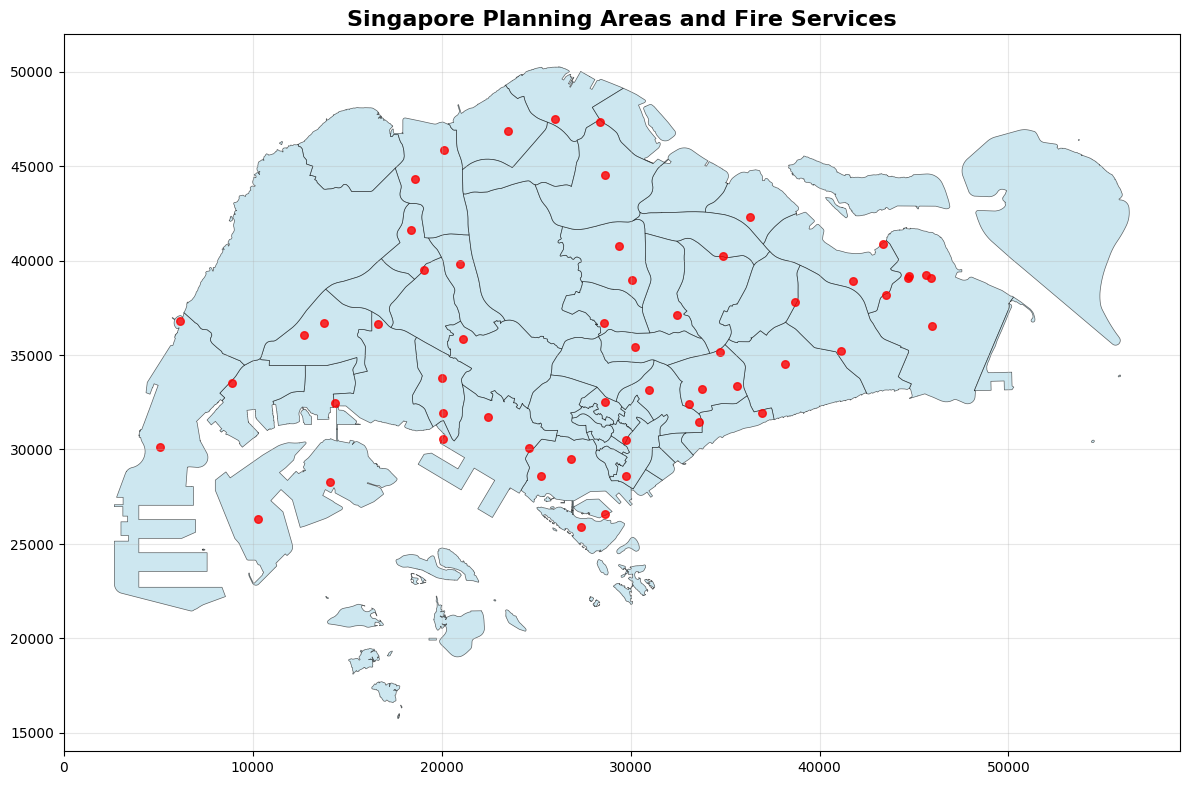

Creating H3 hexagon grid (resolution=8)...
H3 error: Unrecognized type: <class 'dict'>
Falling back to manual hexagon creation...
Creating manual hexagon grid targeting ~3000 hexagons...
Calculated hex radius: 445m
✅ Created 1845 manual hexagons


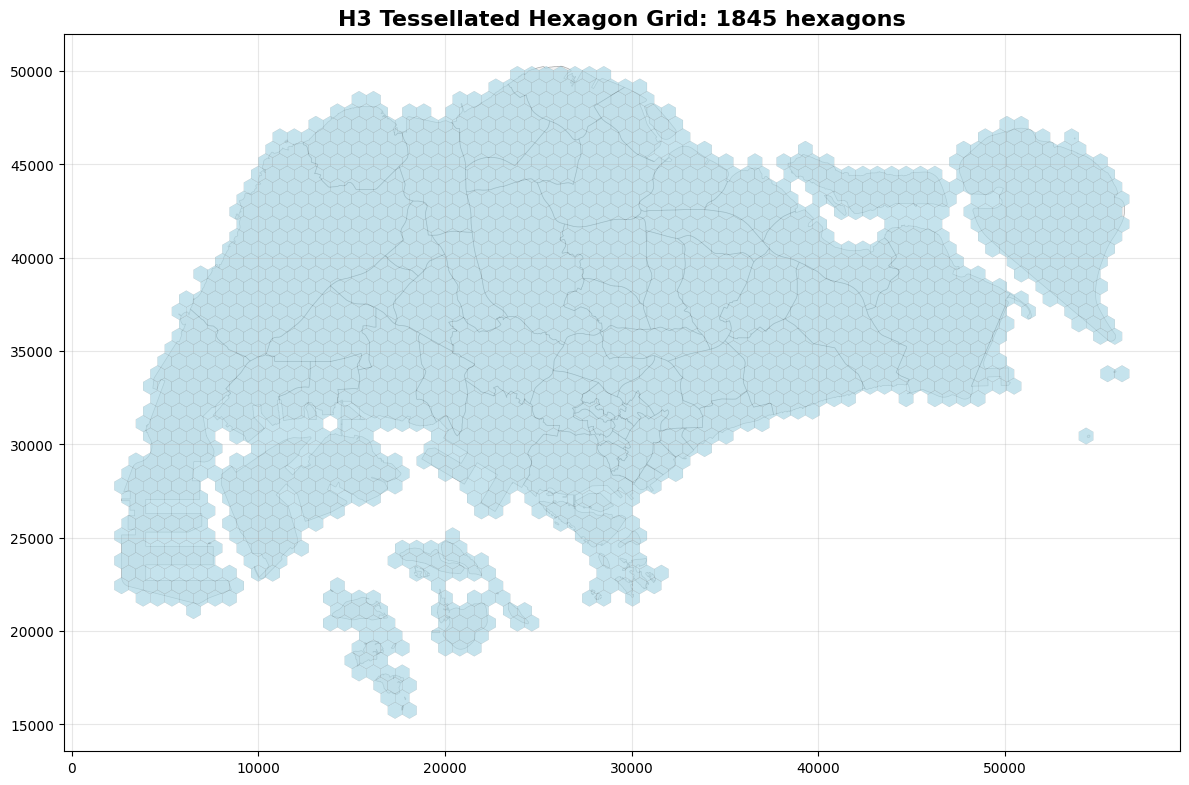

Calculating distance matrix...
Distance range: 0.01km - 52.79km


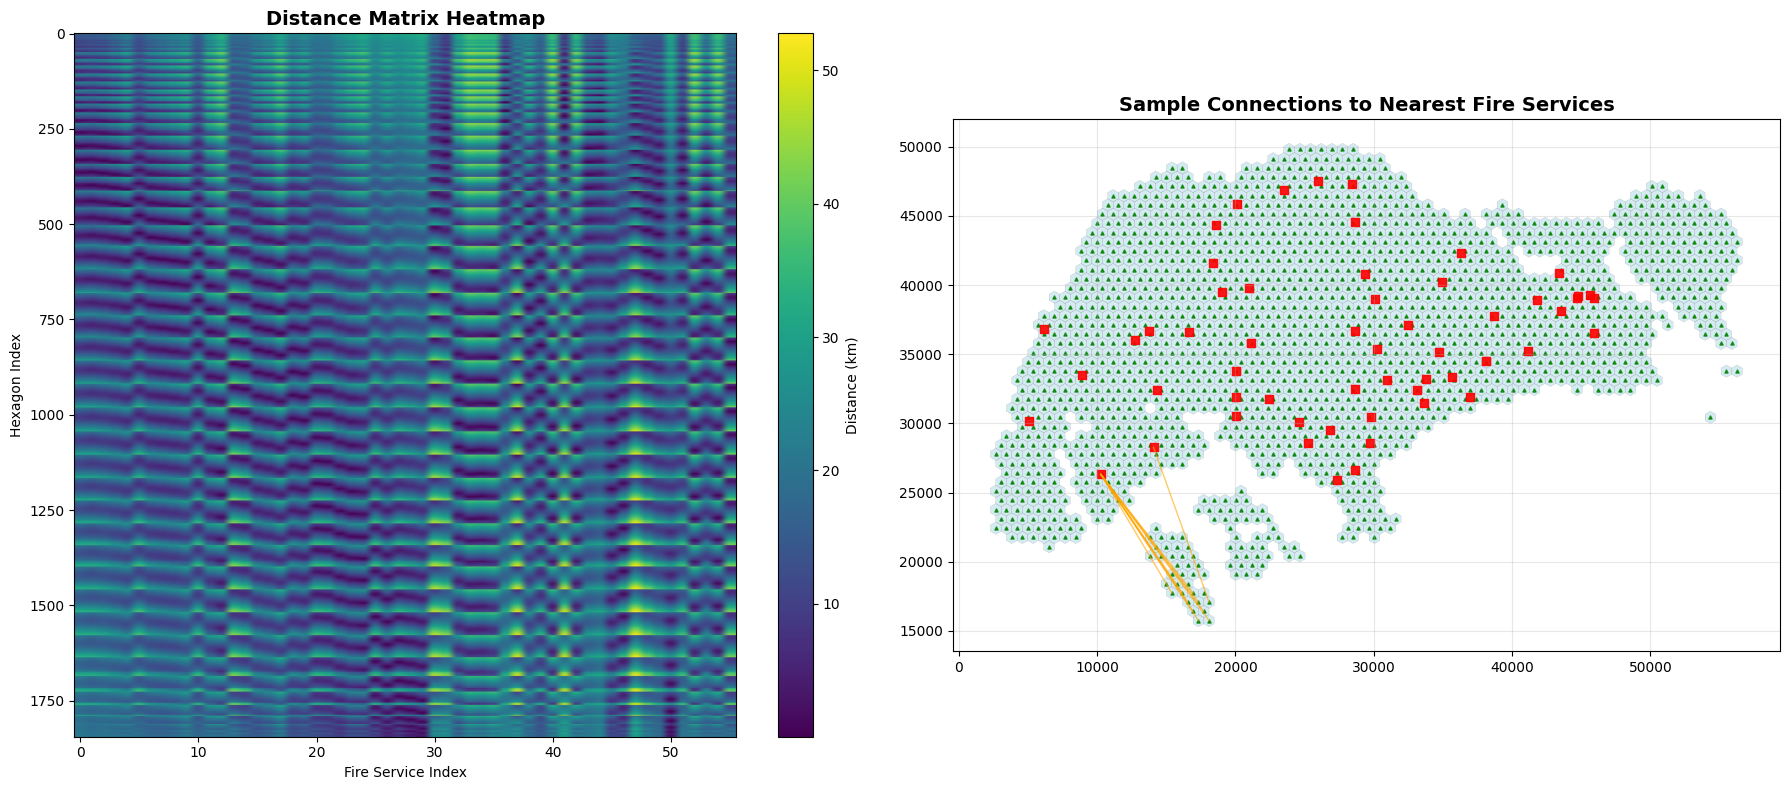

Calculating Hansen accessibility (power=2)...
Accessibility range: 10.81 - 15927.49
Mean: 186.84, Std: 627.61


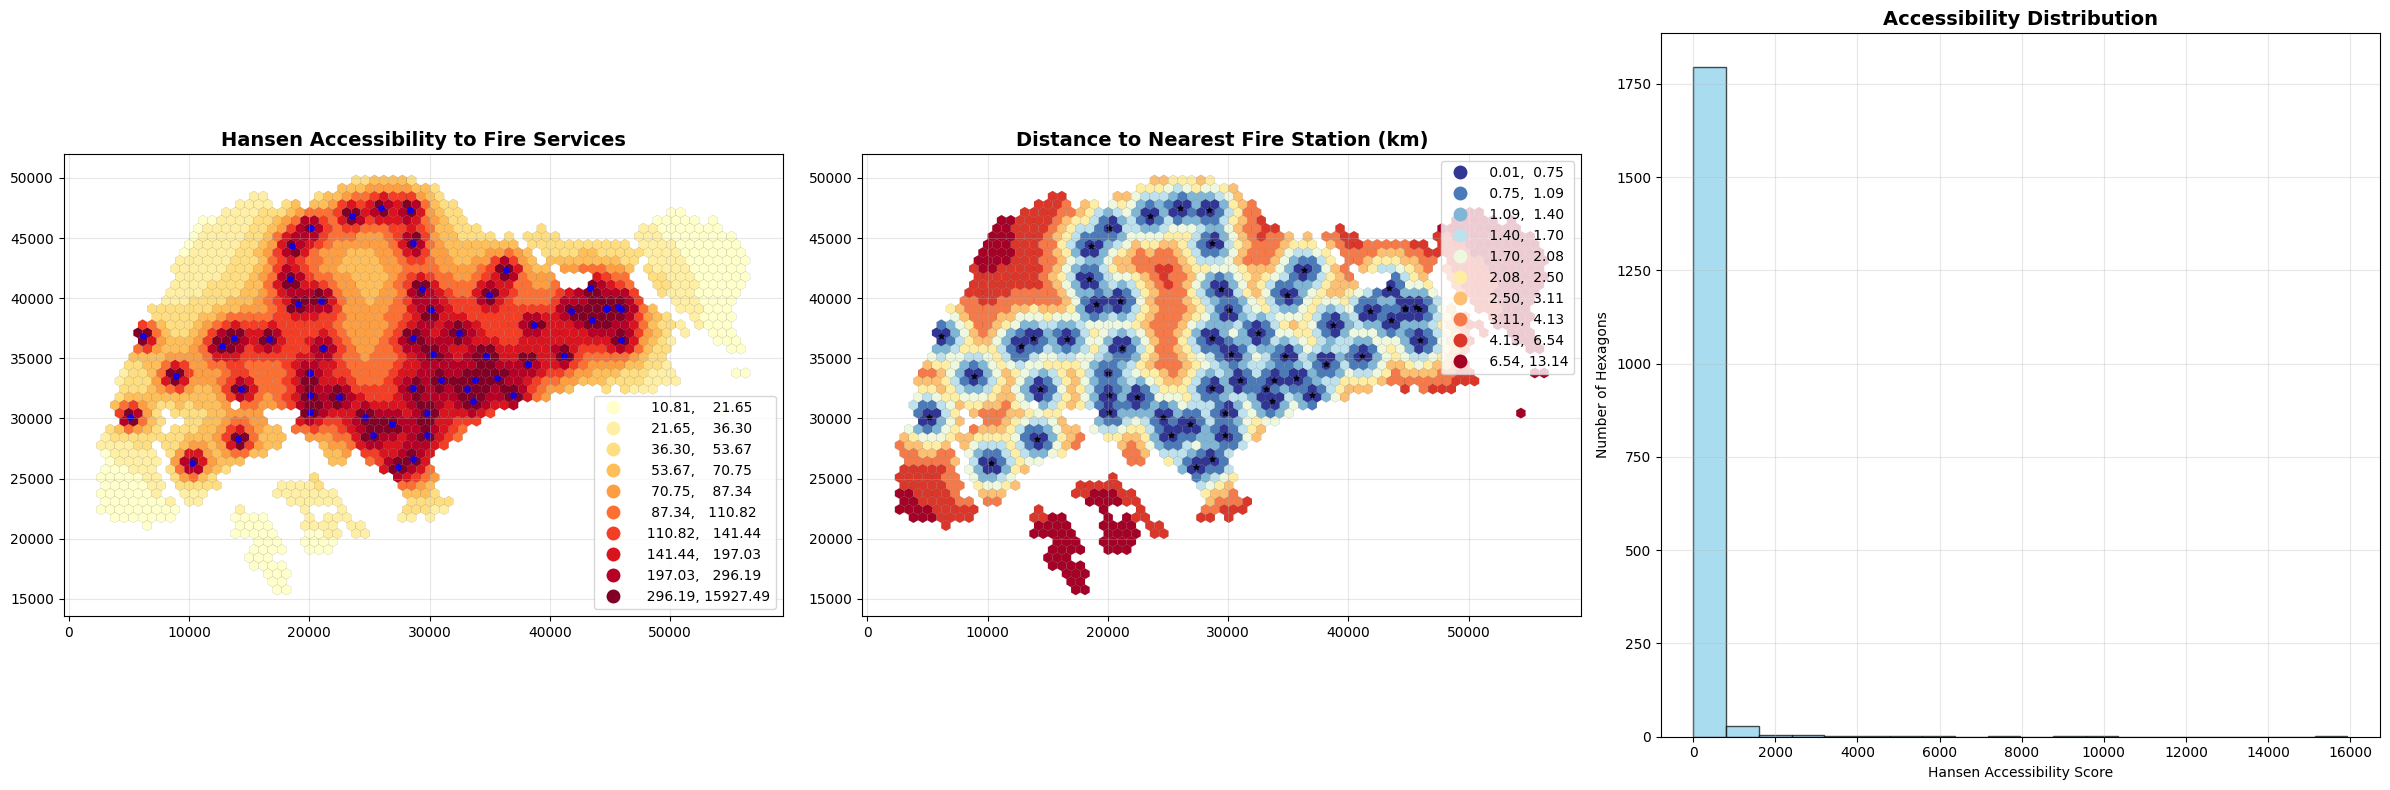


Detailed Statistics:
Hansen Accessibility:
  Mean: 186.84
  Std: 627.61
  Min: 10.81
  Max: 15927.49

Distance to Nearest Fire Station:
  Mean: 2.85km
  Max: 13.14km


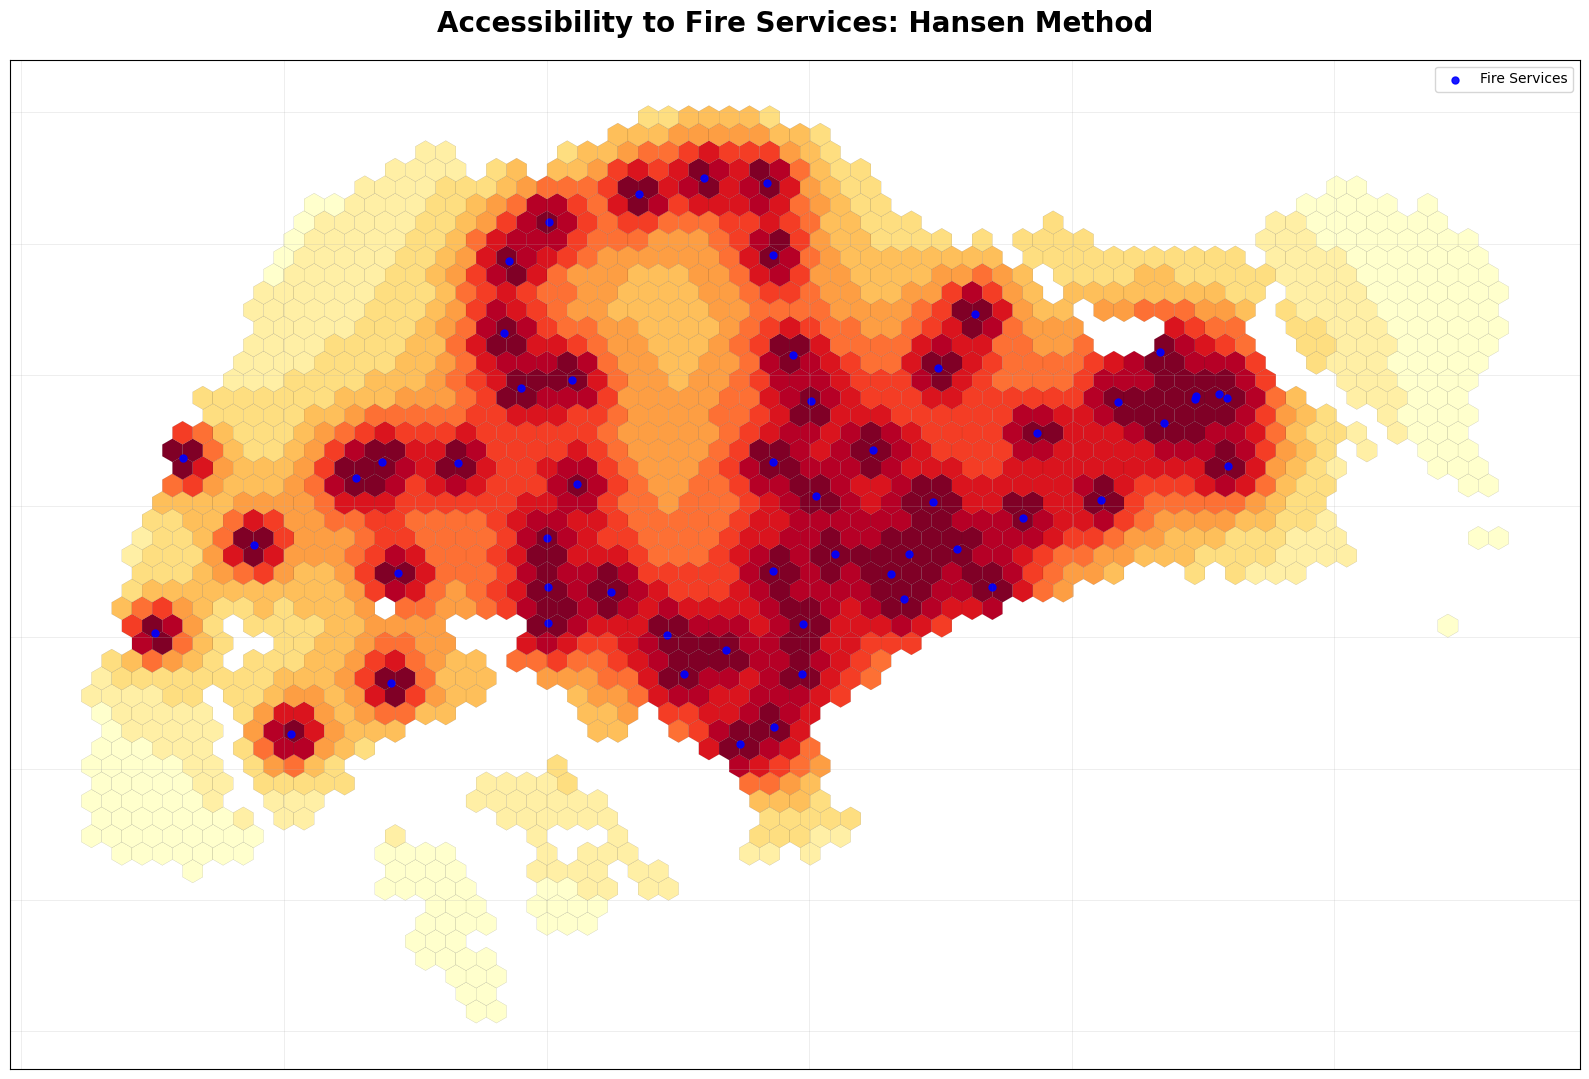


ANALYSIS COMPLETE
Created H3 tessellated hexagon grid with perfect tessellation
Results show accessibility patterns based on distance to fire services.
Red areas = high accessibility, Yellow areas = low accessibility


In [29]:
results = run_complete_fire_accessibility_analysis()


Creating statistical visualization by planning region...
Available columns in planning data: ['PLN_AREA_N', 'geometry']
Found region column: PLN_AREA_N
Analyzing 2437 hexagons (from 2437) across regions
Unique regions: 55


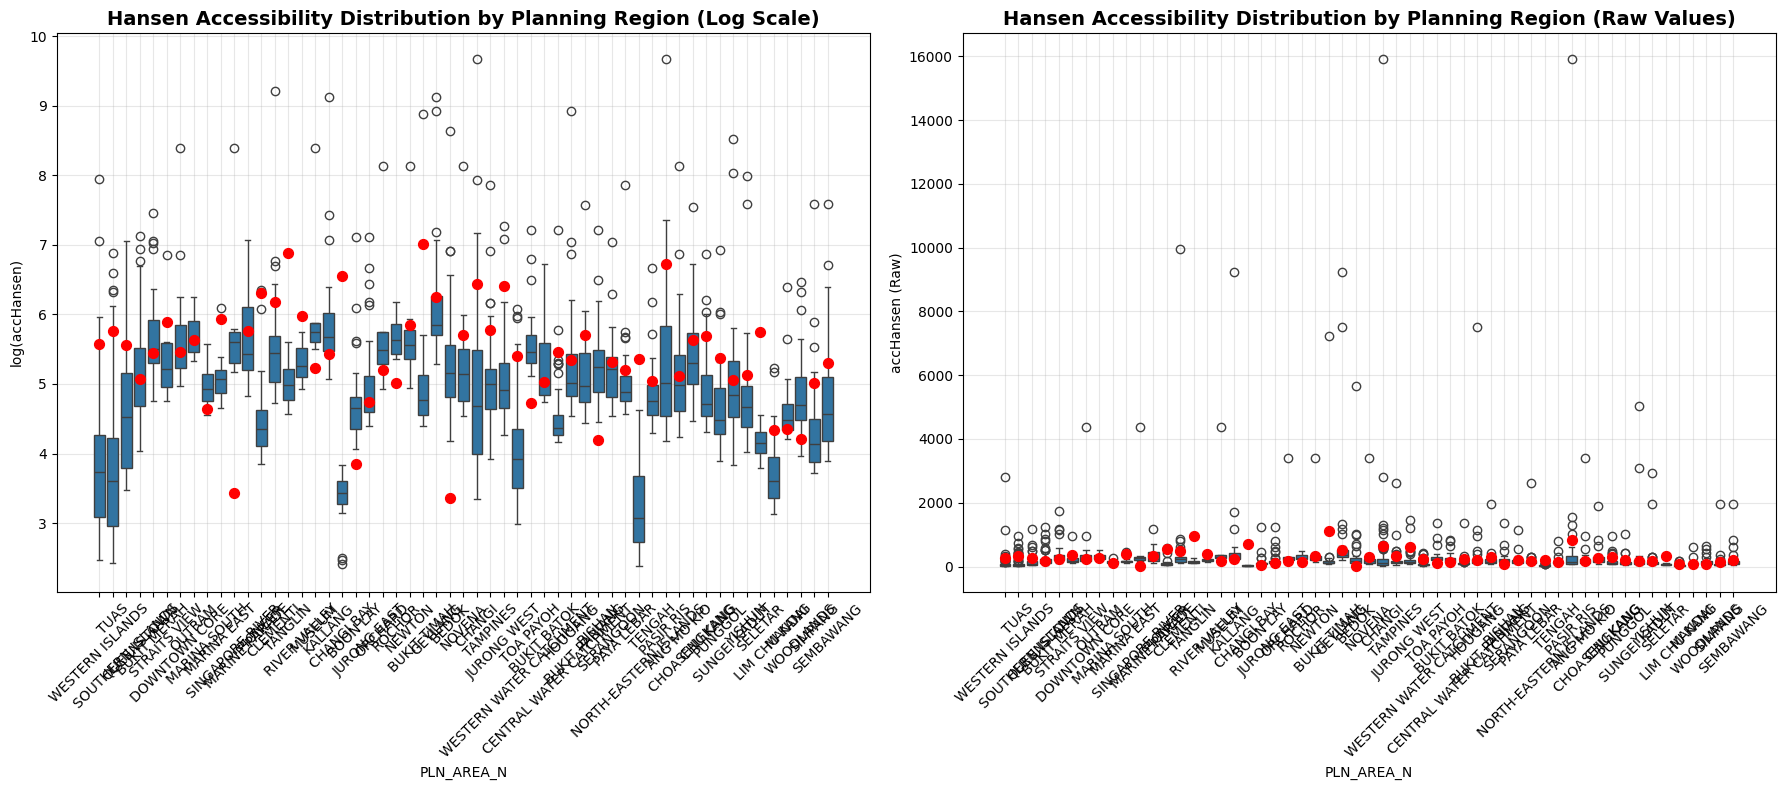


=== Hansen Accessibility Statistics by PLN_AREA_N ===
                         count      mean       std      min        max
PLN_AREA_N                                                            
ANG MO KIO                  43   263.567   512.466   69.270   3393.557
BEDOK                       59   317.950   731.871   64.932   5652.836
BISHAN                      25   260.642   264.118   86.080   1356.375
BOON LAY                    30   159.145   216.887   57.930   1227.393
BUKIT BATOK                 35   232.778   180.353  114.494    827.370
BUKIT MERAH                 45   363.719   317.345  116.918   1727.198
BUKIT PANJANG               29   235.591   339.584   84.582   1953.062
BUKIT TIMAH                 52   278.346   984.884   80.912   7229.608
CENTRAL WATER CATCHMENT     98   103.814   133.300   64.571   1356.375
CHANGI                     105   379.773  1572.658   28.484  15927.488
CHANGI BAY                  21    30.767     9.878   11.150     46.045
CHOA CHU KANG         

In [30]:
hexagon_with_regions = analyze_hansen_by_region(results)